In [1]:
from processing import monophony
from processing.monophony import *
from models import transformer_encoder_decoder
from models import *

Using TensorFlow backend


In [2]:
monophony._group_subdirs_contents(from_dir='lpd_5/lpd_5_full', to_dir='lpd_5/all')

Total Tracks:  174154


'lpd_5/all'

In [2]:
model = transformer_encoder_decoder(encoder_len=100, decoder_len=200)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 1)]             0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 100, 100)             13500     ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (None, 200, 100)             13500     ['input_2[0][0]']         

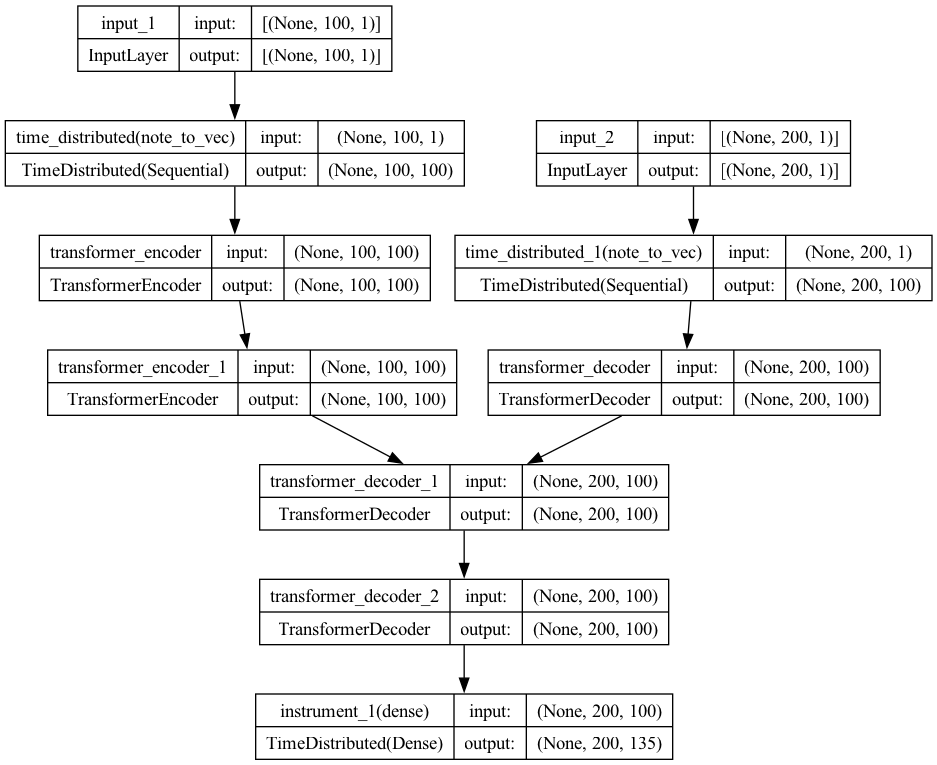

In [3]:
plot_model(model, show_layer_names=True, show_shapes=True)

In [1]:
len(set([1, 2, 1]))

2

In [66]:
#output_sequence_len = 0 if not encoder_decoder else >=1

# Data INFO
# ~175K midi files
# Files could be short melodies, loop compositions or long symphonies or songs
# ~10K midi files in each of the 16 top level subdirectories 
# Considering 300 midi files at present, at 8 resolution..~ 0.2% Dataset
# Generating a polyphonic monophony music (multiple instruments each following a monophonic melody line independently) or type of contrapuntal 
train_source, val_source, test_source  = sample_dataset('./lpd_5/lpd_5_full/0', nsamples=10000, train_size=0.9, val_size=0.2, input_sequence_len=100, output_sequence_len=200, resolution=8, prune_rest_note_percent=0.5, batch_size=128, encoder_decoder=True)

Preparing test dataset...: 100%|██████████| 1000/1000 [01:02<00:00, 15.98it/s]


In [4]:
train_source = ('lpd_5_batched/train_inputs', 'lpd_5_batched/train_outputs')
music_loader = load_music_batches(*train_source, encoder_decoder=True)
steps = len(os.listdir(train_source[0]))-1
steps

10130

In [5]:
val_source = ('lpd_5_batched/val_inputs', 'lpd_5_batched/val_outputs')
val_music_loader = load_music_batches(*val_source, encoder_decoder=True)
val_steps = len(os.listdir(val_source[0]))-1
val_steps

2604

In [ ]:
import tensorflow as tf
import os


class ModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, model, checkpoint_dir, save_best_only=True):
        super(ModelCheckpoint, self).__init__()
        self.model = model
        self.checkpoint_dir = checkpoint_dir
        self.save_best_only = save_best_only
        self.best_val_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if self.save_best_only and val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            filepath = os.path.join(self.checkpoint_dir, f"best_model.h5")
            self.model.save(filepath)
            print(f"Saved model to {filepath} (val_loss: {val_loss:.4f})")
        else:
            filepath = os.path.join(self.checkpoint_dir, f"model_epoch_{epoch}.h5")
            self.model.save(filepath)
            print(f"Saved model to {filepath} (val_loss: {val_loss:.4f})")

modelname = "encoder-decoder-transformer-10Ksamples-1instrument-longer"
checkpoint_dir = f"./{modelname}-checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
model_checkpoint = ModelCheckpoint(model, checkpoint_dir)
callbacks_list = [model_checkpoint]   


In [6]:
history = model.fit(music_loader, steps_per_epoch=steps, validation_data=val_music_loader, validation_steps=val_steps, epochs=50, callbacks=callbacks_list)

Epoch 1/50
10130/10130 [==============================] - 12611s 1s/step - loss: 2.8299 - accuracy: 0.2560 - val_loss: 2.7422 - val_accuracy: 0.2654
Epoch 2/50
10130/10130 [==============================] - 12392s 1s/step - loss: 2.5826 - accuracy: 0.2919 - val_loss: 2.6396 - val_accuracy: 0.2840
Epoch 3/50
10130/10130 [==============================] - 50982s 5s/step - loss: 2.4970 - accuracy: 0.3092 - val_loss: 2.5951 - val_accuracy: 0.2930
Epoch 4/50
10130/10130 [==============================] - 12423s 1s/step - loss: 2.4465 - accuracy: 0.3208 - val_loss: 2.5879 - val_accuracy: 0.2986
Epoch 5/50
10130/10130 [==============================] - 11617s 1s/step - loss: 2.4154 - accuracy: 0.3281 - val_loss: 2.5774 - val_accuracy: 0.2988
Epoch 6/50
10130/10130 [==============================] - 13034s 1s/step - loss: 2.3901 - accuracy: 0.3342 - val_loss: 2.5681 - val_accuracy: 0.3017
Epoch 7/50
10130/10130 [==============================] - 11802s 1s/step - loss: 2.3668 - accuracy: 0.3396

KeyboardInterrupt: 

In [7]:
model.save(modelname)

INFO:tensorflow:Assets written to: encoder-decoder-transformer-10Ksamples-1instrument-longer/assets


INFO:tensorflow:Assets written to: encoder-decoder-transformer-10Ksamples-1instrument-longer/assets


In [2]:
model = tf.keras.saving.load_model('encoder-decoder-transformer-10Ksamples-1instrument-longer')

In [3]:
tracks = sample_track('lpd_5/lpd_5_full/1', nsamples=100, input_sequence_len=100, resolution=8, tokenize_tracks=True)

Sampling tracks...: 100%|██████████| 100/100 [00:01<00:00, 53.09it/s]


In [11]:
x, y = tracks[randint(0, len(tracks)-1)]
composer = compose_music(music_model=model, cue=x, output_seq_len=200, topn=129, encoder_decoder=True, print_gen=True, cue_tokenized=True)



In [12]:
x.shape, y.shape

((100, 1), (5176, 1))

In [13]:
total_track_length = y.shape[0]
composition_length = int(0.5*total_track_length)
TEMPO = 60

print(f"Composing for {composition_length} time steps at {TEMPO} bpm")
for _ in range(composition_length):
    composition = next(composer)
    print(composition[-1])
  


output_midi_path = f'generated_track_transformer.mid'
output_audio_path = f'generated_track_transformer.wav'

print("Composition Done...")
generated_track = make_track(composition, tempo=TEMPO)
print("Track Done...")

multitrack_to_midi(generated_track, output_midi_path)
print("Generated Midi file Done...")

midi_to_wav(output_midi_path, output_audio_path)
print("Generated Audio file Done...")



output_midi_path = 'original_track_transformer.mid'
output_audio_path = 'original_track_transformer.wav'

original_track = make_track(composition=y[:composition_length], tempo=TEMPO, composition_tokenized=False)
print("Original Track Done...")

multitrack_to_midi(original_track, output_midi_path)
print("Original Midi file Done...")
midi_to_wav(output_midi_path, output_audio_path)
print("Original Audio file Done...")

Composing for 2588 time steps at 60 bpm
Generation :  1
[66]
Generation :  2
[72]
Generation :  3
[41]
Generation :  4
[0]
Generation :  5
[73]
Generation :  6
[40]
Generation :  7
[66]
Generation :  8
[66]
Generation :  9
[130]
Generation :  10
[72]
Generation :  11
[0]
Generation :  12
[61]
Generation :  13
[0]
Generation :  14
[0]
Generation :  15
[0]
Generation :  16
[0]
Generation :  17
[130]
Generation :  18
[62]
Generation :  19
[0]
Generation :  20
[130]
Generation :  21
[0]
Generation :  22
[0]
Generation :  23
[51]
Generation :  24
[0]
Generation :  25
[130]
Generation :  26
[130]
Generation :  27
[0]
Generation :  28
[0]
Generation :  29
[130]
Generation :  30
[72]
Generation :  31
[130]
Generation :  32
[0]
Generation :  33
[0]
Generation :  34
[0]
Generation :  35
[0]
Generation :  36
[0]
Generation :  37
[0]
Generation :  38
[130]
Generation :  39
[0]
Generation :  40
[0]
Generation :  41
[0]
Generation :  42
[62]
Generation :  43
[77]
Generation :  44
[0]
Generation :  4

KeyboardInterrupt: 